# Multi-Objective Flow Direction Algorithm (MOFDA) for Task Offloading

This notebook implements the MOFDA algorithm for the task offloading problem based on the paper "Leader selection based Multi-Objective Flow Direction Algorithm. (MOFDA): A novel approach for engineering design problems."

In [10]:
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from task_offloading_moo.pymoo.problem import TaskOffloadingProblem
from task_offloading_moo.pymoo.operators.repair import TaskOffloadingRepair
from task_offloading_moo.pymoo.operators.sampling import TaskOffloadingSampling
from task_offloading_moo.pymoo.algorithms.mofda_optimizer import MOFDAOptimizer
from task_offloading_moo.pymoo.termination.mofda_termination import MOFDATermination

## 1. Implementing MOFDA

First, we'll implement the Multi-Objective Flow Direction Algorithm based on the paper description.

## 2. Problem Setup

Now let's set up the task offloading problem similar to the PUMA notebook.

In [11]:
pop_size = 100
n_max_iters = 50
num_cloud_machines = 30
num_fog_machines = 20
num_tasks = 500

# Add this code above your algorithm definition

algorithm = MOFDAOptimizer(
    repair=TaskOffloadingRepair(),
    use_soft_repair=True,
    pop_size=pop_size,
    sampling=TaskOffloadingSampling(),
    n_max_iters=n_max_iters,
    archive_size=100,
    save_history=True,
    w=0.4,
    c1=2,
    c2=2,
    beta=4,
    delta=0.5
)

problem = TaskOffloadingProblem(num_cloud_machines, num_fog_machines, num_tasks, use_random_machines=True)

## 3. Run Optimization

In [12]:
res = minimize(problem,
               algorithm,
               termination=MOFDATermination(n_max_gen=n_max_iters),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      9 |             - |             -
     2 |      600 |      2 |  3.4584732124 |         ideal
     3 |     1100 |      4 |  1.1879391732 |         ideal
     4 |     1600 |      3 |  0.4126053216 |         ideal
     5 |     2100 |      6 |  0.1742413661 |             f
     6 |     2600 |      1 |  3.262357E+01 |         ideal
     7 |     3100 |      2 |  1.0000000000 |         ideal
     8 |     3600 |      2 |  0.000000E+00 |             f
     9 |     4100 |     11 |  0.8935396427 |         ideal
    10 |     4600 |      3 |  0.0668835813 |         ideal
    11 |     5100 |     12 |  0.6646915849 |         ideal
    12 |     5600 |     18 |  0.1141610664 |         ideal
    13 |     6100 |     14 |  0.0158517015 |         ideal
    14 |     6600 |     14 |  0.000000E+00 |             f
    15 |     7100 |     12 |  0.0152364774 |             f
    16 |     7600 |     20 |  0.0265307454 |         ide

## 4. Visualize Results

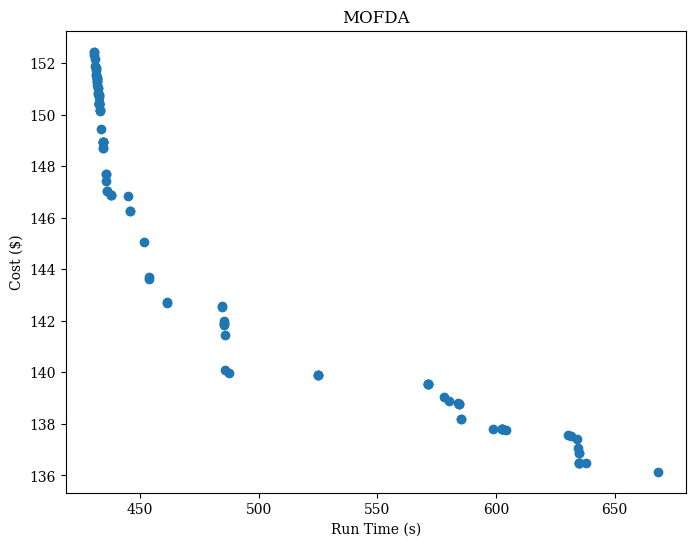

In [13]:
plot = Scatter(title="MOFDA")
plot.add(res.F)
plot.axis_labels = problem.dataset_generator.get_objective_names()
_ = plot.show()

## 5. Create Animation of Optimization Progress

In [14]:
import os
from task_offloading_moo.utils.utils import save_generations_video_pymoo

out_path = os.path.join(os.path.dirname(os.getcwd()), "output")

save_generations_video_pymoo(res.history, out_path, "mofda_video")


## 6. Save pareto results in pkl file

In [15]:
import pickle

out_path = os.path.join(os.path.dirname(os.getcwd()), "output")

output_file = os.path.join(out_path, "mofda_results.pkl")
with open(output_file, "wb") as f:
    pickle.dump(res.F, f)

print(f"Solutions sauvegardées dans {output_file}")

Solutions sauvegardées dans /home/cytech/ING3/MOO/task_offloading_moo/output/mofda_results.pkl
